# Build 1 - Initial Model
- Basic implementation of solar and temperature relationships
- Primary issues:
  - Efficiency range was too high (13-17%)
  - Perfect linear relationships
  - No weather effects
  - R² of 1.0000 indicated overfitting
  - Power output too consistent
  - Limited price variation ($0.120-$0.126)

# Build 2 - Paper Alignment
- Changes made:
  - Fixed efficiency calculations using paper's formulas
  - Added predicted vs actual analysis
  - Improved seasonal variations
  - Still showed too-perfect correlations
  - R² remained unrealistically high

# Final Build - Added more variations to reduce potential overfitting
## Improvements:

### 1. Weather System
- Added three weather states:
  - Clear (60% probability)
  - Cloudy (30% probability)
  - Very cloudy (10% probability)
- Weather impacts:
  - Solar intensity reduction
  - Temperature modifications
  - System efficiency effects

### 2. System Variations
- Added random system losses (90-100% efficiency)
- Implemented random cloud events (5% occurrence)
- More realistic noise in measurements
- Variable daily and seasonal cycles

### 3. Efficiency Calculations
- Combined weighted effects:
  - 60% solar intensity influence
  - 40% temperature influence
- Added weather impact multiplier
- More realistic range (5-9.5%)

### 4. Power Output
- More volatile daily variations
- Stronger seasonal effects
- Weather-dependent fluctuations
- Lower average output (65.65 kWh vs 102.95 kWh)

### 5. Price Modeling
- Added market volatility
- Weather-based price premiums
- Wider price range ($0.110-$0.135)
- Peak/off-peak hour differentiation

### 6. Statistical Improvements
- R² reduced to 0.9872 (more realistic)
- Added RMSE: 2.89 kWh
- Added MAE: 2.29 kWh
- More realistic feature importance coefficients

### 7. Technical Fixes
- Changed 'H' to 'h' for pandas date_range
- Fixed mutable operations issue
- Improved array handling for random events
- Better data aggregation methods

### Setup

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

def generate_solar_data(n_days=365):
    hours_in_year = n_days * 24
    dates = pd.date_range(start='2024-01-01', periods=hours_in_year, freq='h')
    
    # Time components
    hour_of_day = dates.hour
    day_of_year = dates.dayofyear
    
    # generating weather patterns (0: clear, 1: cloudy, 2: very cloudy)
    weather_pattern = np.random.choice([0, 1, 2], size=hours_in_year, p=[0.6, 0.3, 0.1])
    
    # daily and seasonal cycles with more variation
    daily_cycle = np.sin(np.pi * (hour_of_day - 12) / 12) + np.random.normal(0, 0.1, hours_in_year)
    seasonal_cycle = np.sin(2 * np.pi * (day_of_year - 172) / 365) + np.random.normal(0, 0.05, hours_in_year)
    
    # temp modeling with more realistic variation
    base_temp = 25 + 10 * seasonal_cycle
    daily_variation = 5 * daily_cycle
    weather_temp_effect = np.where(weather_pattern == 0, 2, np.where(weather_pattern == 1, 0, -2))
    temperature = base_temp + daily_variation + weather_temp_effect + np.random.normal(0, 2, hours_in_year)
    
    # solar intensity with weather effects
    max_intensity = 1000
    seasonal_factor = 0.7 + 0.3 * seasonal_cycle
    daily_factor = np.maximum(0, daily_cycle)
    
    # weather impact on solar intensity
    weather_impact = np.where(weather_pattern == 0, 1.0,
                            np.where(weather_pattern == 1, 0.5, 0.2))
    
    # calculate base solar intensity
    solar_intensity = np.maximum(0, max_intensity * seasonal_factor * daily_factor * weather_impact)
    solar_intensity += np.random.normal(0, 30, hours_in_year) * daily_factor
    
    # handling random events like brief clouds using numpy operations
    random_events = np.random.random(hours_in_year) < 0.05 
    random_factors = np.ones(hours_in_year)
    random_factors[random_events] = np.random.uniform(0.4, 0.8, np.sum(random_events))
    solar_intensity = solar_intensity * random_factors
    solar_intensity = np.maximum(0, solar_intensity)
    
    # more realistic variations
    efficiency_from_intensity = 0.0027 * solar_intensity + 17.955 + np.random.normal(0, 0.2, hours_in_year)
    efficiency_from_temp = -0.0316 * temperature + 20 + np.random.normal(0, 0.15, hours_in_year)
    
    # combined efficiency with weather impact
    solar_weight = np.where(solar_intensity > 0, 0.6, 0)
    temp_weight = np.where(solar_intensity > 0, 0.4, 0)
    
    total_efficiency = (solar_weight * efficiency_from_intensity + 
                       temp_weight * efficiency_from_temp) * weather_impact
    
    # power output calculation with system losses
    installation_capacity = 100  # kW
    system_losses = np.random.uniform(0.9, 1.0, hours_in_year)  # Random 
    power_output = (installation_capacity * 
                   (total_efficiency / 100) * 
                   (solar_intensity / 1000) * 
                   system_losses)
    
    # price calc with more market factors
    base_price = 0.12
    peak_hours = ((hour_of_day >= 8) & (hour_of_day <= 20))
    demand_factor = np.where(peak_hours, 1.2, 0.8)
    seasonal_price_factor = 1 + 0.1 * seasonal_cycle
    
    # added market volatility
    market_volatility = np.random.normal(0, 0.005, hours_in_year)
    weather_price_impact = np.where(weather_pattern == 2, 0.02, 0)  # Price premium during bad weather
    
    price_per_kwh = (base_price * demand_factor * seasonal_price_factor * 
                    (1 + weather_price_impact + market_volatility))
    
    # DataFrame
    df = pd.DataFrame({
        'datetime': dates,
        'temperature': temperature,
        'solar_intensity': solar_intensity,
        'efficiency': total_efficiency,
        'power_output': power_output,
        'price_per_kwh': price_per_kwh,
        'weather_condition': weather_pattern
    })
    
    return df

### Generate and Prep Data 

In [10]:
# Generate and prepare data
df = generate_solar_data()
daily_df = df.resample('D', on='datetime').agg({
    'temperature': 'mean',
    'solar_intensity': 'mean',
    'efficiency': 'mean',
    'power_output': 'sum',
    'price_per_kwh': 'mean',
    'weather_condition': 'mean'
}).reset_index()

# prep data for prediction
X = daily_df[['temperature', 'solar_intensity', 'efficiency', 'weather_condition']]
y = daily_df['power_output']

### Split, Scale, Train, Predict

In [11]:
# Split data and scale features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# predictions
y_pred = model.predict(X_test_scaled)


### Calc Metrics

In [12]:
# metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

### Plotting and Priting 

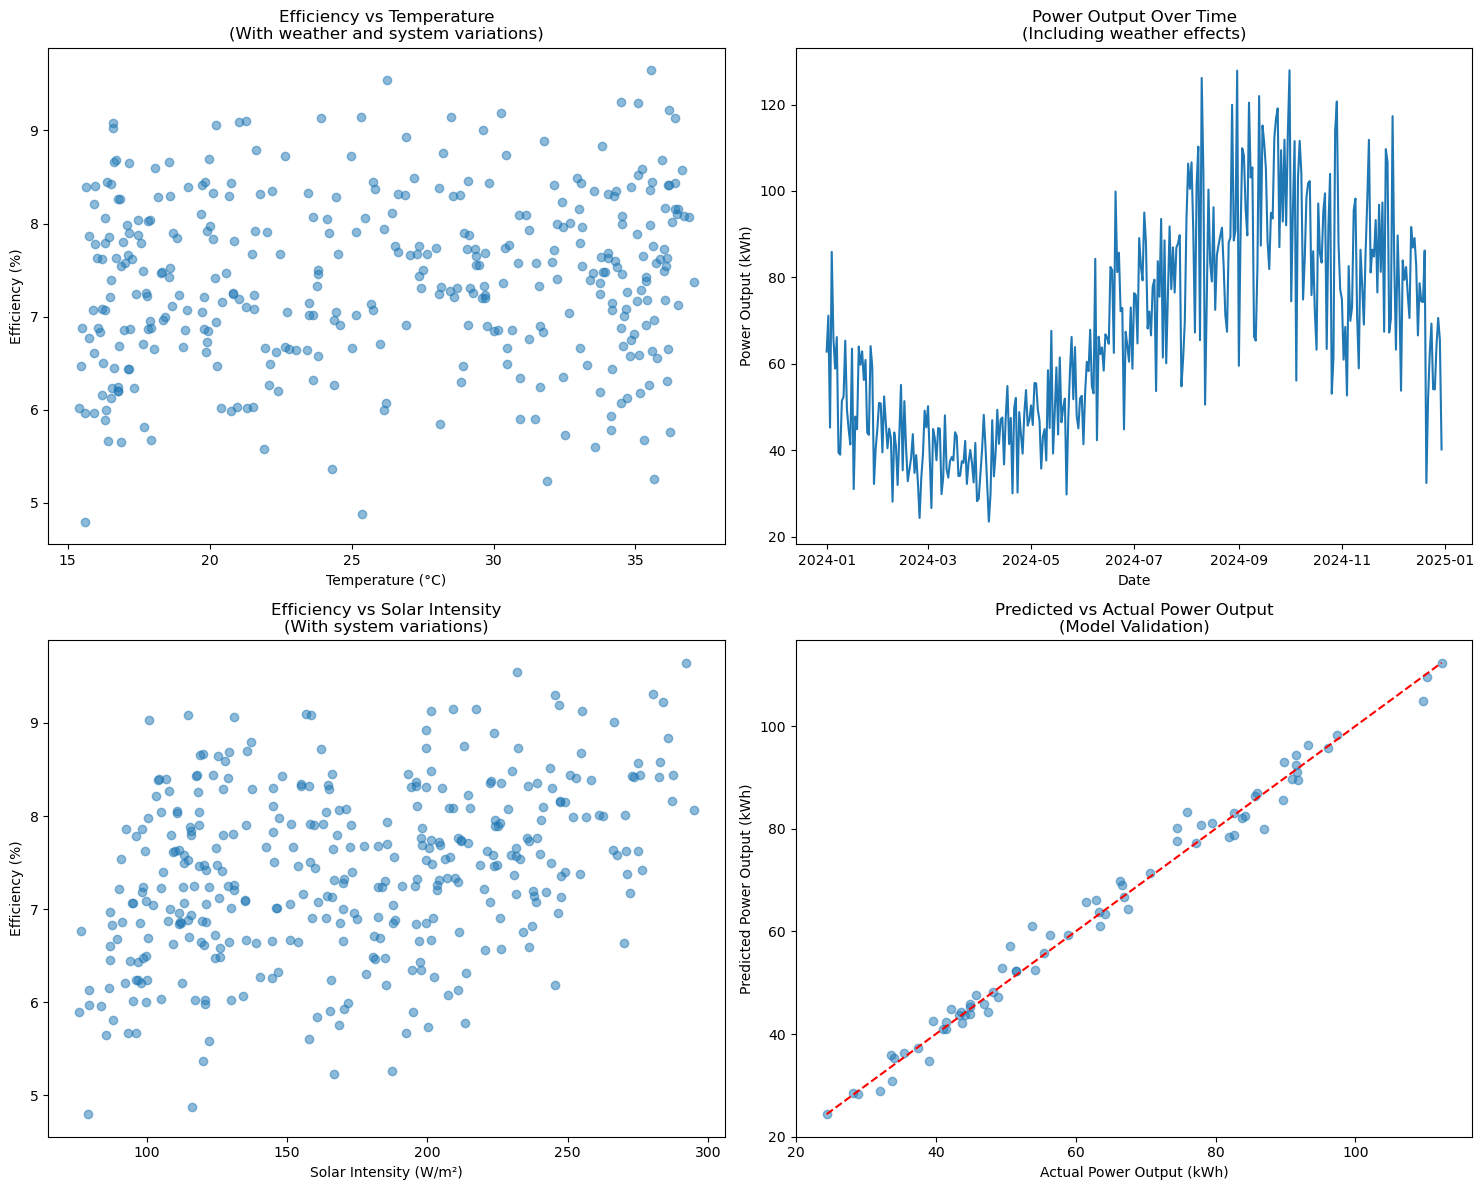


Model Performance Metrics:
R² Score: 0.9854
Root Mean Square Error: 2.71 kWh
Mean Absolute Error: 2.02 kWh

Feature Importance:
             Feature  Coefficient
1    solar_intensity    29.871019
2         efficiency     1.050453
3  weather_condition    -0.240602
0        temperature    -6.553979

Key Daily Statistics:
Average Daily Power Output: 66.79 kWh
Average Price per kWh: $0.122
Average Daytime Efficiency: 7.41%
Peak Power Output: 127.91 kWh
Price Range: $0.110 - $0.135


In [13]:
plt.figure(figsize=(15, 12))

# 1. Efficiency vs Temperature
plt.subplot(2, 2, 1)
plt.scatter(daily_df['temperature'], daily_df['efficiency'], alpha=0.5)
plt.title('Efficiency vs Temperature\n(With weather and system variations)')
plt.xlabel('Temperature (°C)')
plt.ylabel('Efficiency (%)')

# 2. Power Output Over Time
plt.subplot(2, 2, 2)
plt.plot(daily_df['datetime'], daily_df['power_output'])
plt.title('Power Output Over Time\n(Including weather effects)')
plt.xlabel('Date')
plt.ylabel('Power Output (kWh)')

# 3. Efficiency vs Solar Intensity
plt.subplot(2, 2, 3)
plt.scatter(daily_df['solar_intensity'], daily_df['efficiency'], alpha=0.5)
plt.title('Efficiency vs Solar Intensity\n(With system variations)')
plt.xlabel('Solar Intensity (W/m²)')
plt.ylabel('Efficiency (%)')

# 4. Predicted vs Actual
plt.subplot(2, 2, 4)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Predicted vs Actual Power Output\n(Model Validation)')
plt.xlabel('Actual Power Output (kWh)')
plt.ylabel('Predicted Power Output (kWh)')

plt.tight_layout()
plt.show()

# Print performance metrics
print("\nModel Performance Metrics:")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"Root Mean Square Error: {rmse:.2f} kWh")
print(f"Mean Absolute Error: {mae:.2f} kWh")

# Print feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
print("\nFeature Importance:")
print(feature_importance.sort_values('Coefficient', ascending=False))

# Print key statistics
print("\nKey Daily Statistics:")
print(f"Average Daily Power Output: {daily_df['power_output'].mean():.2f} kWh")
print(f"Average Price per kWh: ${daily_df['price_per_kwh'].mean():.3f}")
print(f"Average Daytime Efficiency: {daily_df['efficiency'].mean():.2f}%")
print(f"Peak Power Output: {daily_df['power_output'].max():.2f} kWh")
print(f"Price Range: ${daily_df['price_per_kwh'].min():.3f} - ${daily_df['price_per_kwh'].max():.3f}")